## Experiment ToolKit Documendation  
This notebook aims to explain the Experiment ToolKit and it's usage easily.

What is the Experiment ToolKit?  
Like every other toolKit, the Experiment ToolKit handles a specific type of data in a project. Here, the data is a metadata of experiments inside a Projects.

The structure of classes inherations related to the Experiment ToolKit:

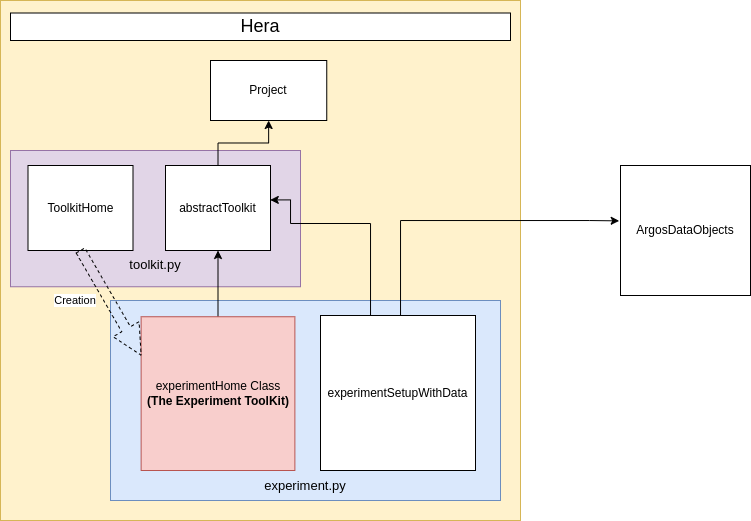

In [23]:
from IPython.display import Image
Image(filename="ExperimentToolKit.png")

## Example:  

We have a metadata of devices and it's locations related to an experiment held at Haifa in 2014.  
The data is a json file inside the path "haifafluxes2014/runtimeExperimentData/HaifaFluxes2014/data.json".  
We want to parse this data and load it to an experimentSetupWithData instance. The experimentSetupWithData is also a type of a toolKit which includes the metadata itself and also inherates from the argos.  
Let's create an experimentSetupWithData instance with a project name "exampleProjectforDocumentation" and add to it the metadata (by addMeasurementsDocument): 

In [42]:
from hera.measurements.experiment.experiment import experimentSetupWithData
import os
import pandas
from hera.datalayer import datatypes

projectName = "exampleProjectforDocumentation"

experiment_setup_data = experimentSetupWithData(projectName=projectName, pathToExperiment="haifafluxes2014")
deviceTable = experiment_setup_data.trialSet['Measurements']['Measurement'].entitiesTable("design")
prop = deviceTable[['stationName', 'latitude', 'longitude']].drop_duplicates()
loc = experiment_setup_data.entitiesTable.query("entityType=='Station'")
stationTable = pandas.merge(prop, loc, left_on="stationName", right_on="name", how="left").drop(['stationName'], axis=1)

instruments_type_list = ["Sonic", "TRH"]

for station_indx, stationData in stationTable.iterrows():
    station_name = stationData.loc['name']
    for instruments_type in instruments_type_list:
        heightList = deviceTable.query("stationName==@station_name and entityType==@instruments_type").height
        for deviceHeight in heightList:
                path_to_data = "/data3/Campaigns_Data/parquetData/2014_Haifa_Fluxes"
                file_name = os.path.join(path_to_data, station_name, instruments_type, str(int(deviceHeight)))
                meta = dict(stationName=station_name, deviceType=instruments_type, deviceHeight=float(deviceHeight),experimentName=experiment_setup_data.name)
                for doc in experiment_setup_data.getMeasurementsDocuments(type="Experiment_rawData", **meta):
                    doc.delete()
            
                experiment_setup_data.addMeasurementsDocument(type="Experiment_rawData",
                                                   resource=file_name,
                                                   dataFormat=datatypes.PARQUET,
                                                   desc=meta)

The length of the measurements documents:

In [43]:
print(len(experiment_setup_data.getMeasurementsDocuments()))

36


The first document:

In [45]:
print(json.dumps(experiment_setup_data.getMeasurementsDocuments()[0].desc, indent=4, sort_keys=True))

{
    "deviceHeight": 9.0,
    "deviceType": "Sonic",
    "experimentName": "HaifaFluxes2014",
    "stationName": "Check_Post"
}


Now let's create an instance of the experimentHome class, and add the connect it with the project we created (by creating experimentSetupWithData, we created an project with the name we specified):

In [46]:
from hera import toolkitHome

expHome = toolkitHome.getToolkit(toolkitName=toolkitHome.EXPERIMENT, projectName=projectName)

Now, we add the DataSource with the experiment_setup_data.name and experiment path (the current):

In [49]:
expHome.addDataSource(experiment_setup_data.name, experimentPath=os.getcwd(), resource="", dataFormat=datatypes.PARQUET)

<Measurements: Measurements object>

The documents inised the Experiment ToolKit now:

In [50]:
expHome.getExperimentsMap()

{'HaifaFluxes2014': {'dataFormat': 'parquet',
  'resource': '',
  'experimentPath': '/home/salo/Projects/2024/experimentToolKit',
  'toolkit': 'experimentToolKit',
  'datasourceName': 'HaifaFluxes2014',
  'version': [0, 0, 1]}}

The experiment toolKit is basically a toolKit that holdes all the datasources of to the metadata of experiments related to a specific project.

In [51]:
expHome.getExperimentsTable()

,dataFormat,resource,experimentPath,toolkit,datasourceName,version
0,parquet,,/home/salo/Projects/2024/experimentToolKit,experimentToolKit,HaifaFluxes2014,"[0, 0, 1]"
